In [135]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

### Importing the Apple stock market CSV 

In [136]:
apple_df = pd.read_csv("AAPL.csv")
apple_df.Date = pd.to_datetime(apple_df.Date, format = '%Y-%m-%d')
df = apple_df[["Date", "Close"]]
df.set_index('Date', inplace = True)
df

,Close
Date,
2015-11-17,28.422501
2015-11-18,29.322500
2015-11-19,29.695000
2015-11-20,29.825001
2015-11-23,29.437500
...,...
2020-11-10,115.970001
2020-11-11,119.489998
2020-11-12,119.209999


### Plotting the stock market data

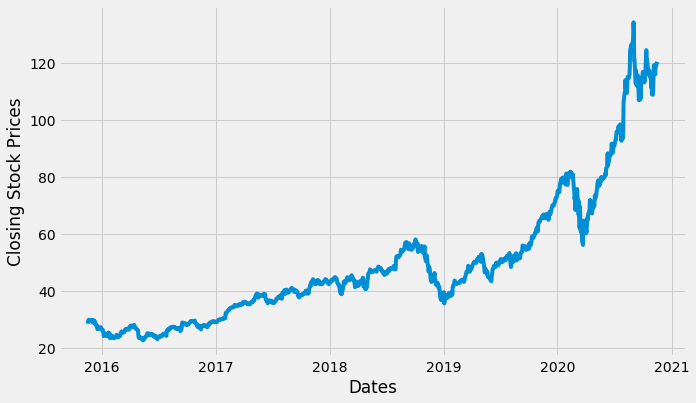

In [137]:
plt.figure(figsize=(10,6))
plt.xlabel('Dates')
plt.ylabel('Closing Stock Prices')
plt.plot(df.Close)
plt.show()

#### Converting the above dataframe into an nupmy array

In [138]:
data = df.filter(['Close'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * 0.9)
training_data_len

1134

#### Normalizing the data 

In [139]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset.reshape(-1,1))
scaled_data

array([[0.05230971],
       [0.06037458],
       [0.06371254],
       ...,
       [0.86585425],
       [0.86630233],
       [0.87562175]])

#### Splitting the dataset

In [140]:
train_data = scaled_data[0:training_data_len, :]
xtrain = []
ytrain = []

for i in range(60, len(train_data)):
    xtrain.append(train_data[i-60:i, 0])
    ytrain.append(train_data[i, 0])
    if i <=60:
        print(xtrain)
        print(ytrain)
        print()

[array([0.05230971, 0.06037458, 0.06371254, 0.06487748, 0.06140509,
       0.06393656, 0.06203236, 0.0615395 , 0.06263724, 0.06048658,
       0.05811193, 0.05569246, 0.06427261, 0.06259242, 0.06248042,
       0.05663338, 0.05786551, 0.05116718, 0.04959902, 0.04514091,
       0.04704512, 0.04175816, 0.03514944, 0.03806175, 0.03783774,
       0.04092926, 0.03962992, 0.03691923, 0.04122049, 0.03803935,
       0.03342446, 0.03362607, 0.02771183, 0.02320893, 0.01368789,
       0.01483042, 0.01834761, 0.02155115, 0.01579373, 0.02056544,
       0.01521126, 0.01415836, 0.01444958, 0.01335187, 0.02482191,
       0.02038624, 0.02161835, 0.00689996, 0.00840091, 0.01568171,
       0.01364309, 0.00927463, 0.01346387, 0.01402394, 0.0082441 ,
       0.01046196, 0.01041713, 0.00880416, 0.00752722, 0.00817689])]
[0.01411354527246983]



In [141]:
xtrain = np.array(xtrain)   # Converting the lists into numpy array
ytrain = np.array(ytrain)

In [142]:
 xtrain = np.reshape(xtrain, (xtrain.shape[0],xtrain.shape[1],1)) # The LSTM model expects the data to be in the 3D shape hence reshaping our data from 2D.
xtrain.shape

(1074, 60, 1)

### Building the LSTM model

In [143]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (xtrain.shape[1],1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [144]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')  #Compiling the model

In [145]:
model.fit(xtrain, ytrain, batch_size = 1, epochs = 1)   #Training the model

1074/1074 [==============================] - 19s 18ms/step - loss: 7.4942e-04


In [146]:
test_data = scaled_data[training_data_len - 60:, :]   #Test dataset
xtest = []
ytest = dataset.reshape(-1,1)[training_data_len:, :]
for i in range(60, len(test_data)):
    xtest.append(test_data[i-60:i, 0])

In [147]:
xtest = np.array(xtest)   #Same as above converting into array and then reshaping
xtest = np.reshape(xtest, (xtest.shape[0], xtest.shape[1], 1))

### Predicting the value of the model

In [148]:
predictions = model.predict(xtest)
predictions = scaler.inverse_transform(predictions)

In [149]:
rmse = np.sqrt(np.mean(((predictions - ytest)**2)))
rmse

4.523033590616526

### Plotting the predicted value of stock

<ipython-input-150-e17be3a9cd12>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


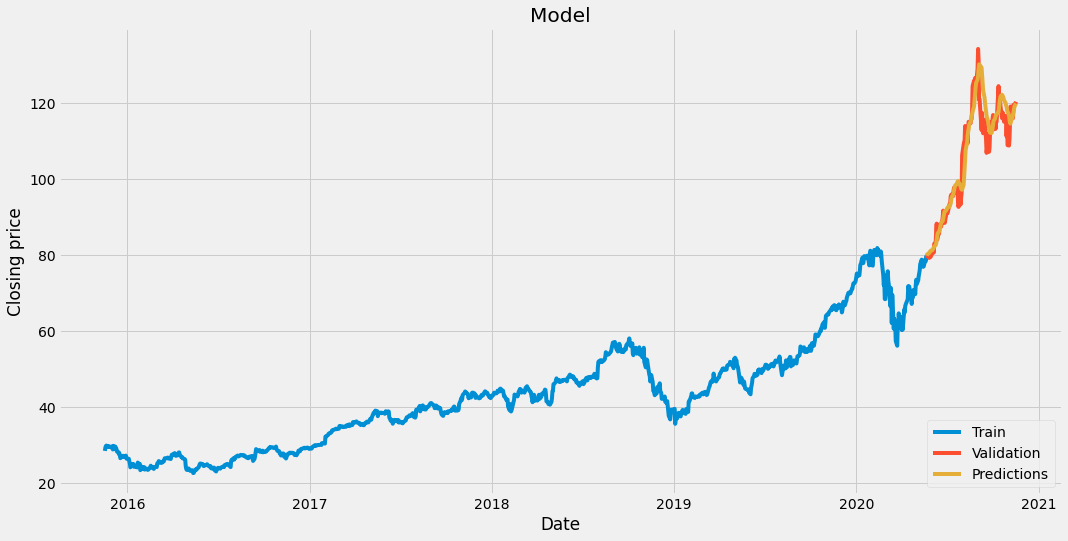

In [150]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
plt.figure(figsize = (16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Validation', 'Predictions'], loc = 'lower right')
plt.show()

In [151]:
valid

,Close,Predictions
Date,,
2020-05-21,79.212502,79.796890
2020-05-22,79.722504,80.139503
2020-05-26,79.182503,80.479271
2020-05-27,79.527496,80.722229
2020-05-28,79.562500,80.928009
...,...,...
2020-11-10,115.970001,116.919914
2020-11-11,119.489998,117.496208
2020-11-12,119.209999,118.312813


In [152]:
#Predicting the values for next day 
last_60_days = df[-60:].values
days_scaled = scaler.transform(last_60_days)
x_test = []
x_test.append(days_scaled)
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1], 1))
pred_price = model.predict(x_test)
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[120.52261]]
